# Using pytorch to estimate group based trajectory models

[Andy Wheeler](mailto:apwheele@gmail.com)

This code illustrates using pytorch to estimate group based trajectory models. The idea is basically we have some outcome that is a function of time, so say a regression equation of the form:

$$
\begin{matrix}
 y = 1.0 + 0.5(t) + 0.0(t^2) + \epsilon_1 & \text{: Group 1 Model} \\ 
 y = 0.0 + 0.0(t) + 1.5(t^2) + \epsilon_2 & \text{: Group 2 Model} 
\end{matrix}
$$

But we don't know whether an observation belongs to group 1 or group 2 (the latent classes or clusters), and we also do not know the actual equation for the time trajectory (so we need to estimate the coefficients that we multiply by $t$).

Here I am going to illustrate using [*PyTorch*](https://pytorch.org/) to estimate these models using a simple, simulated example. First the upfront libraries I need, and setting the seed. 

In [1]:
####################################
#Set up needed to run this code

import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
#if you don't have a GPU change this to cpu
#it runs pretty fast either way with this small of data
#device = torch.device("cpu")
device = torch.device("cuda:0")
####################################

Next I simulate some data. Here I do two groups (same as the initial equations I showed earlier) with 50 individuals in each group and 11 time points. To note I am doing the simulations in long data format (many gbtm models make you have the data in wide format). This makes it easier though to pipe in new variables, and it also allows you to do unbalanced panel data in this format as well. I include `t0` (a constant term), as this allows me to estimate the intercept in the subsequent pytorch model.

In [2]:
##############################################
#Simulate data
n_obs = 50 #per group
periods = 11

#Group coefficients
gc = [(1.0, 0.5, 0.0),
      (0.0, 0.0, 1.5)]
gc_np = np.array(gc).transpose()
gps = len(gc)

#Creating panel data over time in long format
t = np.tile(range(periods), n_obs*gps)
id_col = np.repeat(range(n_obs*gps), periods)
group_col = np.repeat(range(gps), n_obs*periods)
t_dat = pd.DataFrame( zip(id_col, group_col, t), columns=['ID','group','t'])

#Latent classes (long format)
lat_np = pd.get_dummies(t_dat.group).to_numpy()

#Prepping the time design matrix
center = periods/2
t_dat['t0'] = 1
center = periods/2
t_dat['t1'] = (t_dat['t']-center)/center
t_dat['t2'] = t_dat['t1']**2
vars = ['t0','t1','t2']
t_np = t_dat[vars].to_numpy() #this is our design matrix

#Now creatings the outcome data
pred_full = t_np.dot(gc_np) #This gives us predictions for both groups
y = (pred_full * lat_np).sum(axis=1) #Element wise multiplication here

#Add some error to the true underlying curves
y_werr = y + np.random.uniform(low=-0.05, high=0.05, size=y.shape)
t_dat['outcome'] = y_werr

#Show what the data looks like in the end
t_dat

,ID,group,t,t0,t1,t2,outcome
0,0,0,0,1,-1.000000,1.000000,0.527132
1,0,0,1,1,-0.818182,0.669421,0.542984
2,0,0,2,1,-0.636364,0.404959,0.695183
3,0,0,3,1,-0.454545,0.206612,0.797608
4,0,0,4,1,-0.272727,0.074380,0.863487
...,...,...,...,...,...,...,...
1095,99,1,6,1,0.090909,0.008264,0.061558
1096,99,1,7,1,0.272727,0.074380,0.077348
1097,99,1,8,1,0.454545,0.206612,0.301391
1098,99,1,9,1,0.636364,0.404959,0.626088


This shows the two groups over time (you can clearly pick them out from the plot) and the typical error. So this should be a fairly easy problem to solve (much easier than real data). This also prints out the mean square error for the true data, so I should not be able to fit a model that has any less error than this (if I am, it is over-fitting). 

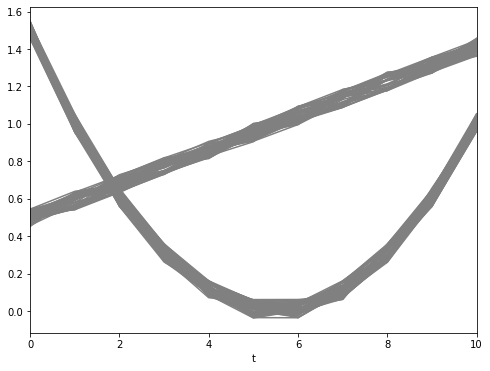

Mean Square Error compared to true trajectory


0.9370665441703778

In [3]:
#Plot to show the functions
fig, ax = plt.subplots(figsize=(8,6)) 
t_dat.groupby('ID').plot(kind='line', x='t', y='outcome', ax=ax, c='grey', legend=False)
plt.show()

#Should add in what the best case loss is (mean square error)
print("Mean Square Error compared to true trajectory")
((y - y_werr)**2).sum()

Next is the actual good stuff. Basically I create a module class to host my parameters, and do the subsequent manipulations to go from my time series data, coefficients, and the latent classes to the end predicted result. The example is borrowed pretty heavily from the pytorch [example documentation](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html).

To do this in practice you need to choose the number of groups beforehand (and well as how to estimate the function over time). 

It takes quite a few iterations to converge in this example using the Adam optimizer. (For this simulation it did not converge to the correct estimates when using stochastic gradient descent.) This prints out the loss in a loop, and so you can see that here it took around 25k iterations to get where it needed to be! But we do see the results calm down to the error that we pretty much expected based on how I simulated the data.

In [4]:
##############################################
#Adapted heavily from
#https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

class LatGBTM(torch.nn.Module):
    def __init__(self, groups, poly, obs, periods):
        """
        Construct parameters for the coefficients and the 
        latent groups 
        Note that poly includes the intercept, so a quadratic
        function should be poly=3
        """
        super(LatGBTM, self).__init__()
        self.coef = torch.nn.Linear(groups, poly, bias=False)
        self.latent_flat = torch.nn.Linear(groups, obs, bias=False)
        #setting the default weights for latent to equal prob
        #torch.nn.init.constant_(self.latent_flat, 1/float(groups))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        #here periods could also be long tensor with varying N
        latent_expand = self.latent_flat.weight.repeat_interleave(periods, -2)
        #softmax to scale probabilities to sum to 1
        pred_groups = torch.mm(x, self.coef.weight) * torch.nn.functional.softmax(latent_expand, 1)
        #sum up to get the final predictions!
        y_pred = torch.sum(pred_groups, 1)
        return y_pred
        

#Set up a basic object
model = LatGBTM(groups=2, poly=3, obs=100, periods=11)
#Initialize latent weights to equal probability (maybe do 0 here instead?)
torch.nn.init.constant_(model.latent_flat.weight, 1/float(2))
criterion = torch.nn.MSELoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
#SGD converged faster, but not even close right answers!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#Now create the data tensors for my input data (time points)
#And outcome data
x_ten = torch.Tensor(t_np)
y_ten = torch.Tensor(y_werr)

#Needs alot of iterations to converge!
for t in range(30000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_ten)

    # Compute and print loss
    loss = criterion(y_pred, y_ten)
    if t % 1000 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
##############################################

99 638.4146728515625
1099 458.09051513671875
2099 338.63336181640625
3099 262.8341064453125
4099 215.86953735351562
5099 184.10838317871094
6099 158.9413299560547
7099 136.25038146972656
8099 114.6995849609375
9099 92.67115020751953
10099 71.51577758789062
11099 53.634376525878906
12099 40.28346252441406
13099 30.74210548400879
14099 23.511497497558594
15099 17.468568801879883
16099 12.363271713256836
17099 8.303993225097656
18099 5.275670051574707
19099 3.1743240356445312
20099 1.8652191162109375
21099 1.1816942691802979
22099 0.9176636934280396
23099 0.8551831245422363
24099 0.8466705083847046
25099 0.8454619646072388
26099 0.8452392220497131
27099 0.8452112674713135
28099 0.8452098965644836
29099 0.8452096581459045


And now we can check out how close our actual coefficients are, as well as our latent trajectories.

The order of the groups is not meaningful (here they line up, but if you run with a different set of starting parameters they may be swapped). But you can see we are kind of close in terms of coefficients. We have some coefficients that should be 0 off by ~0.1. 

For the latent classes, we need to apply the softmax function to get our probabilities. You can see that they did not converge to 0/1 (most are around 95% in the correct group), but are stacked up like you would expect. So even this simple problem did not perfectly recover the correct groupings.

In [5]:
##############################################
#Model coefficients
print( model.coef.weight )
#Probabilities need to use softmax function
torch.nn.functional.softmax(model.latent_flat.weight, 1)
##############################################

Parameter containing:
tensor([[-0.0722,  1.0735],
        [-0.0400,  0.5390],
        [ 1.6049, -0.1103]], requires_grad=True)


tensor([[0.0752, 0.9248],
        [0.0583, 0.9417],
        [0.0534, 0.9466],
        [0.0596, 0.9404],
        [0.0752, 0.9248],
        [0.0708, 0.9292],
        [0.0669, 0.9331],
        [0.0837, 0.9163],
        [0.0635, 0.9365],
        [0.0672, 0.9328],
        [0.0786, 0.9214],
        [0.0796, 0.9204],
        [0.0524, 0.9476],
        [0.0792, 0.9208],
        [0.0783, 0.9217],
        [0.0504, 0.9496],
        [0.0669, 0.9331],
        [0.0698, 0.9302],
        [0.0535, 0.9465],
        [0.0793, 0.9207],
        [0.0675, 0.9325],
        [0.0741, 0.9259],
        [0.0664, 0.9336],
        [0.0662, 0.9338],
        [0.0478, 0.9522],
        [0.0613, 0.9387],
        [0.0633, 0.9367],
        [0.0669, 0.9331],
        [0.0598, 0.9402],
        [0.0669, 0.9331],
        [0.0559, 0.9441],
        [0.0628, 0.9372],
        [0.0644, 0.9356],
        [0.0660, 0.9340],
        [0.0656, 0.9344],
        [0.0828, 0.9172],
        [0.0561, 0.9439],
        [0.0616, 0.9384],
        [0.0

Here I make a plot to illustrate how close the estimated trajectories are compared to the true trajectories. And you can see they line up pretty well. 

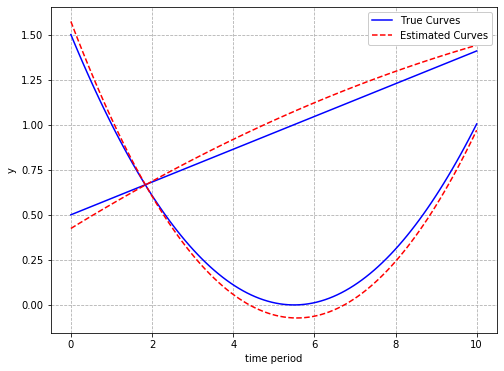

In [6]:
##############################################
#Making graphs to show actual trajectories vs the estimated ones

t_orig = np.linspace(0,periods-1,100)
t_cent = (t_orig - center)/center
t_design = pd.DataFrame( zip(t_cent**0, t_cent, t_cent**2)).to_numpy()

#Actual
true_curve = t_design.dot(gc_np)

#Estimated
est_coef_np = model.coef.weight.detach().numpy()
est_curve = t_design.dot(est_coef_np)

#Now superimposing on a plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_orig, true_curve[:,0], color='b', label='True Curves')
ax.plot(t_orig, true_curve[:,1], color='b')
ax.plot(t_orig, est_curve[:,0], linestyle='--', color='r', label='Estimated Curves')
ax.plot(t_orig, est_curve[:,1], linestyle='--', color='r')
ax.set_xlabel('time period')
ax.set_ylabel('y')
ax.grid(True,linestyle='--')
ax.legend(facecolor='white', framealpha=1)
plt.show()
##############################################

So this is a nice illustration, but there are a bunch of things I would need to update to make it viable in practice. Some of those things are:

 1. A function to estimate the latent classes for out of sample data. 
 2. Different loss functions for count or binomial data.
 3. The ability to estimate an equation predicting the latent class.
 4. Standard errors/covariances for model coefficients.
 
For 1, you want to do [cross-validation](https://www.tandfonline.com/doi/abs/10.1080/03610926.2012.719986) to figure out the correct number of classes. But that isn't directly possible in this code. I have an idea how to do it (use the coefficients to solve for the latent classes, then estimate the error), but I need to confer with others to see how they solve the problem.

For 2 my work often uses counts over time, or it is common in criminology to be looking at binary 0/1 data as well. That you should just need to update the loss function and a link function for the `forward()` prediction. So I don't think that will be much work.

For 3 we often want to estimate an equation that predicts the latent classes based on time-invariant characteristics. I'm not sure how to do that in this set up though.

This is basically set up out of the box to model however complicated temporal functions you wanted though, and can also incorporate inconsistently measured panel data. So if you had one observation measured at time periods `[1,3,4,8]`, and another measured at `[2,3.4,6,9.1]` this code would just work out of the box. If you did not want to do polynomial time functions, but something [like splines](https://link.springer.com/article/10.1007/s40865-016-0025-6), you just feed it those functions. Also can incorporate whatever other time varying attributes as well.

You might also want to have a model for balanced vs unbalanced data. For balanced data with array broadcasting, you really only need to fit the outcome vector into memory. So can potentially do this for giant datasets. 

For 4 I don't know if you can get standard errors for the coefficients using the gradients. I know you can do Bayesian MCMC [modelling in Tensorflow](https://blogs.rstudio.com/tensorflow/posts/2019-05-06-tadpoles-on-tensorflow/), so maybe that is a way to get posterior distributions for the coefficients.

Also don't take this as the best way to fit these models. Not sure if there are potential optimizations internally into how I created the `forward()` function to do the prediction, nor of the optimizer (this is basically just me doing the predictions and seeing if the machine could figure it out!). So I have no clue if those are written in the best way possible. If you follow the link before about cross-validation, these models tend to be notorious to fit in practice, and so maybe doing a better job with the initial starting parameters would go along way. Pytorch ends up being a pretty simple & fast tool through to fit these equations.

If you have suggestions always feel free to get in touch!